In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from nltk import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/aliceliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aliceliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
url = "https://raw.githubusercontent.com/AliceLiu17/csc448_final/main/data/combined_data_clean.csv"
df = pd.read_csv(url)

df.head()

,label,email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Understanding the data

In [3]:
df.shape

(8029, 2)

In [4]:
df["email"].unique()

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ...,
       ' thank you for shopping with us gifts for all occasions free gift with NUMBER NUMBER purchase for a limited time only receive this NUMBER plush santa bear free with your purchase of NUMBER NUMBER or more when your order totals NUMBER NUMBER or more order must be NUMBER NUMBER or more before shipping and handling this santa bear is added to your cart for free while supplies last mary s store would like to thank you for being a valued customer as our way of saying thanks to you the customer we are offering a NUMBER discount on all purchases made during the month of november just enter the word thanks in the discount code box during checkout to re

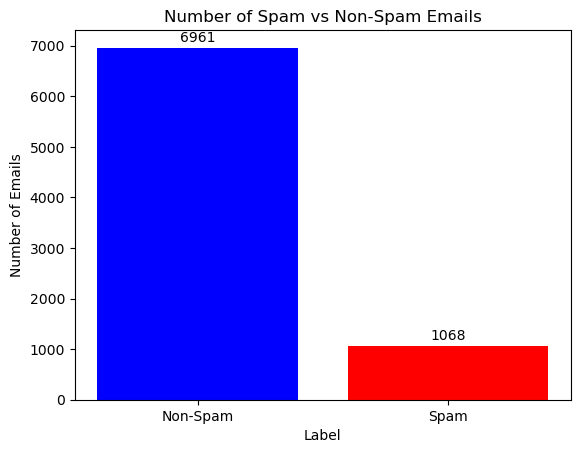

In [5]:
# spam vs non-spam of the original df
spam_counts = df['label'].value_counts()

# bar plot
plt.bar(spam_counts.index, spam_counts.values, color=['blue', 'red'])
plt.xlabel('Label')
plt.ylabel('Number of Emails')
plt.title('Number of Spam vs Non-Spam Emails')

for i, count in enumerate(spam_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

plt.xticks([0, 1], ['Non-Spam', 'Spam'])  
plt.show()

## EDA + Data Preprocessing

In [6]:
# handle different languages
from langdetect import detect
from googletrans import Translator

In [7]:
df['email'] = df['email'].astype(str)  

In [8]:
## find the number of rows that has chinese in their email
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'N/A'

## Are emails that are NOT English indicate spam?
No, it's not a sole indicator. As we see for email that are NOT english:

In [9]:
df['language'] = df['email'].apply(detect_language)
non_english_rows = df[df['language'] != 'en']
non_english_labels = non_english_rows['label']

non_english_rows_count = df[df['language'] != 'en'].shape[0]

In [11]:
print("Number of non-english emails:", non_english_rows_count)

Number of non-english emails: 515


In [12]:
print("Spam/Non-spam ratio for non-english emails:")
print(non_english_labels.value_counts())

Spam/Non-spam ratio for non-english emails:
0    485
1     30
Name: label, dtype: int64


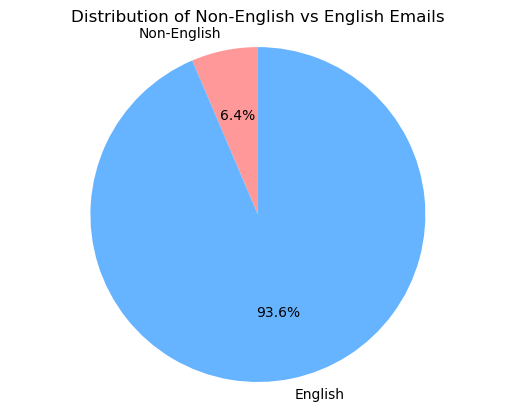

In [13]:
english_rows_count = df[df['language'] == 'en'].shape[0]

# create pi chart for nonenglish VS english:
labels = ['Non-English', 'English']
sizes = [non_english_rows_count, english_rows_count]
colors = ['#ff9999', '#66b3ff']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')

plt.title('Distribution of Non-English vs English Emails')
plt.show()

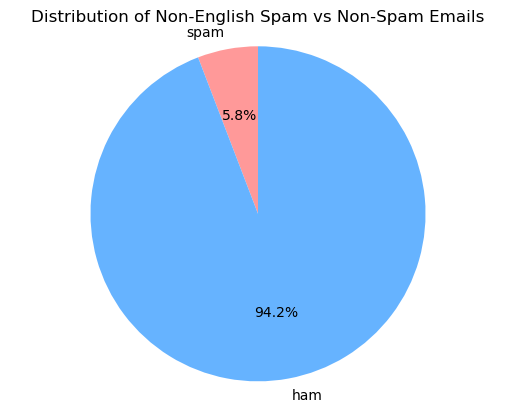

In [14]:
non_english_spam_count = non_english_rows[non_english_rows['label'] == 1].shape[0]
non_english_non_spam_count = non_english_rows[non_english_rows['label'] == 0].shape[0]

# create pi chart for non-english SPAM vs HAM:
labels = ['spam', 'ham']
sizes = [non_english_spam_count, non_english_non_spam_count]
colors = ['#ff9999', '#66b3ff']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')

plt.title('Distribution of Non-English Spam vs Non-Spam Emails')
plt.show()

### Translating all emails to English
**PROBLEM:** Translation may not be accurate

Should we drop the rows? Considering how there's technically only 584/8029 emails that are non-english?

### ATTEMPT0: Dropping non-english emails

In [15]:
df['language'] = df['email'].apply(detect_language)


df_en = df[df['language'] == 'en']
df_en = df_en.drop(columns=['language'])
df_en.head()

,label,email
0,0,"Go until jurong point, crazy.. Available only ..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...


### Other data preprocessing:
1. Convert everything to lowercase 
2. Tokenization
3. Removing stopwords

**Might not do word lemmatization since an indicator of a scam email are words that are spelled incorrectly, and I don't want the words to be shorten

In [16]:
# convert everything to lower case
df_en["email"] = df_en["email"].str.lower()

In [17]:
# # word stemming = remove the end or beginning of the words
# def word_stemming(words):
#     stem_words = [stemmer.stem(o) for o in words]
#     return " ".join(stem_words)

# # word lemminzation = convert word back to base form using dictionary
# def word_lemmatizer(words):
#    lemma_words = [lemmatizer.lemmatize(o) for o in words]
#    return " ".join(lemma_words)

In [18]:
# tokenize and count words
def tokenize_count(text):
    words = re.findall(r'\b\w+\b', text)
    return Counter(words)

In [19]:
# remove stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and re.match(r'\b\w+\b', word)]
    return ' '.join(filtered_words)

In [31]:
# print(stop_words)

In [32]:
# add more stopwords that are present in the data
# additional_stopwords = {
#     ''
# }

### df_en analysis: n-gram frequency chart
#### UNARY

In [20]:
# apply to remove stopwords
df_en['cleaned_email'] = df_en['email'].apply(remove_stopwords)

In [21]:
# apply email to tokenize and count words
word_count = df_en["cleaned_email"].apply(tokenize_count)
total_word_count = sum(word_count, Counter())

In [22]:
word_frequency_df_en = pd.DataFrame(total_word_count.items(), columns=['Word', 'Frequency'])
word_frequency_df_en = word_frequency_df_en.sort_values(by='Frequency', ascending=False) # sort descending

word_frequency_df_en.head(20)

,Word,Frequency
1479,number,32410
436,url,8240
4535,list,2108
612,get,1879
551,one,1799
60,like,1441
384,time,1428
684,people,1327
16,free,1316
675,would,1316


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/3436898210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_words['Frequency'] = top_10_words['Frequency'].astype(int)


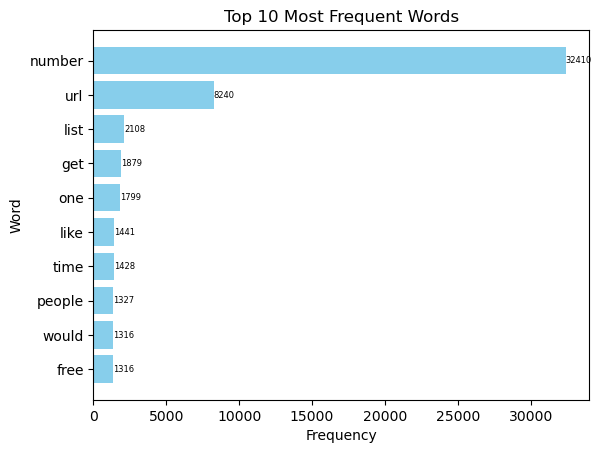

In [24]:
## chart to see highest freq word and their count
top_10_words = word_frequency_df_en.head(10)
top_10_words['Frequency'] = top_10_words['Frequency'].astype(int)
top_10_words = top_10_words.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_words['Word'], top_10_words['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Words')

for index, value in enumerate(top_10_words['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

### df_ham analysis
#### UNARY

In [29]:
df_en_ham = df_en[df_en['label'] == 0] ## df_en of non-spam

In [30]:
ham_word_count = df_en_ham["cleaned_email"].apply(tokenize_count)
ham_total_word_count = sum(ham_word_count, Counter())
ham_word_frequency_df = pd.DataFrame(ham_total_word_count.items(), columns = ['Word', 'Frequency'])
ham_word_frequency_df = ham_word_frequency_df.sort_values(by='Frequency', ascending=False)
ham_word_frequency_df.head()

,Word,Frequency
1084,number,26009
291,url,7308
3464,list,1775
433,get,1431
373,one,1428


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/3444029849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_words_ham['Frequency'] = top_10_words_ham['Frequency'].astype(int)


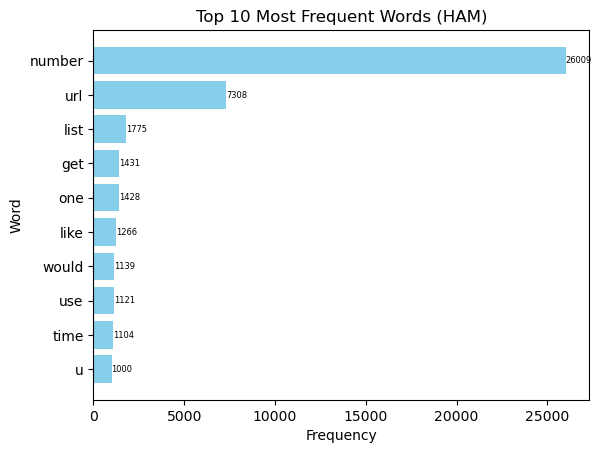

In [32]:
## chart to see highest freq word and their count
top_10_words_ham = ham_word_frequency_df.head(10)
top_10_words_ham['Frequency'] = top_10_words_ham['Frequency'].astype(int)
top_10_words_ham = top_10_words_ham.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_words_ham['Word'], top_10_words_ham['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Words (HAM)')

for index, value in enumerate(top_10_words_ham['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

### df_spam analysis
#### UNARY

In [27]:
df_en_spam = df_en[df_en['label'] == 1] ## df of spam
spam_word_count = df_en_spam["cleaned_email"].apply(tokenize_count)
spam_total_word_count = sum(spam_word_count, Counter())
spam_word_frequency_df = pd.DataFrame(spam_total_word_count.items(), columns = ['Word', 'Frequency'])
spam_word_frequency_df = spam_word_frequency_df.sort_values(by='Frequency', ascending=False)
spam_word_frequency_df.head()

,Word,Frequency
515,number,6401
2795,url,932
0,free,803
2781,hyperlink,625
392,e,510


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/1007751731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_words_spam['Frequency'] = top_10_words_spam['Frequency'].astype(int)


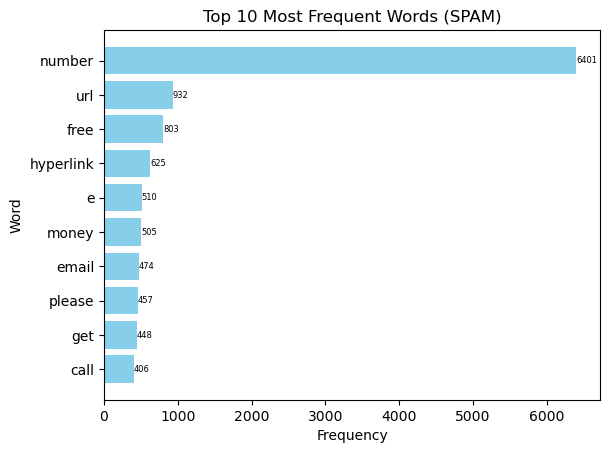

In [38]:
## chart to see highest freq word and their count
top_10_words_spam = spam_word_frequency_df.head(10)
top_10_words_spam['Frequency'] = top_10_words_spam['Frequency'].astype(int)
top_10_words_spam = top_10_words_spam.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_words_spam['Word'], top_10_words_spam['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Words (SPAM)')

for index, value in enumerate(top_10_words_spam['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

### N-Gram Model: bigram and trigram

In [35]:
def tokenize_count_ngrams(text, n):
    words = re.findall(r'\b\w+\b', text.lower())  # Convert to lowercase and use a regex to extract words
    ngrams_list = list(ngrams(words, n))
    return Counter(ngrams_list)

In [39]:
## df_en BIGRAM
bigram_count = df_en['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 2))
total_bigram_count = sum(bigram_count, Counter())
bigram_frequency_df_en = pd.DataFrame(total_bigram_count.items(), columns=['Bigram', 'Frequency'])
bigram_frequency_df_en = bigram_frequency_df_en.sort_values(by='Frequency', ascending=False)

bigram_frequency_df_en.head(20)

,Bigram,Frequency
18182,"(number, number)",16188
32447,"(url, url)",1432
35250,"(number, url)",854
32444,"(mailing, list)",769
33764,"(url, number)",678
43475,"(url, date)",561
38851,"(rpm, list)",513
39933,"(sep, number)",426
23945,"(e, mail)",385
32734,"(url, ________________________________________...",373


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/728473070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams['Frequency'] = top_10_bigrams['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/728473070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams['Bigram'] = top_10_bigrams['Bigram'].apply(lambda x: ' '.join(x))


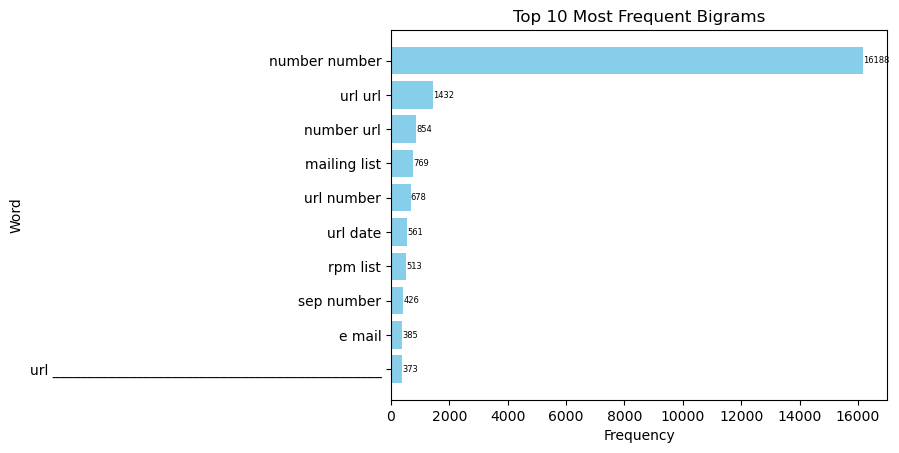

In [42]:
## chart to see highest freq word and their count
top_10_bigrams = bigram_frequency_df_en.head(10)
top_10_bigrams['Frequency'] = top_10_bigrams['Frequency'].astype(int)
top_10_bigrams['Bigram'] = top_10_bigrams['Bigram'].apply(lambda x: ' '.join(x))
top_10_bigrams = top_10_bigrams.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_bigrams['Bigram'], top_10_bigrams['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Bigrams')

for index, value in enumerate(top_10_bigrams['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

In [43]:
## df_en TRIGRAM
trigram_count = df_en['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 3))
total_trigram_count = sum(trigram_count, Counter())
trigram_frequency_df_en = pd.DataFrame(total_trigram_count.items(), columns=['Trigram', 'Frequency'])
trigram_frequency_df_en = trigram_frequency_df_en.sort_values(by='Frequency', ascending=False)

trigram_frequency_df_en.head(20)

,Trigram,Frequency
33559,"(number, number, number)",9414
45799,"(url, url, date)",544
41336,"(number, url, number)",440
41337,"(url, number, url)",432
45801,"(date, number, number)",301
41830,"(number, sep, number)",295
45800,"(url, date, number)",295
45803,"(number, numbertnumber, number)",293
45802,"(number, number, numbertnumber)",293
45804,"(numbertnumber, number, number)",293


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/883552463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams['Frequency'] = top_10_trigrams['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/883552463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams['Trigram'] = top_10_trigrams['Trigram'].apply(lambda x: ' '.join(x))


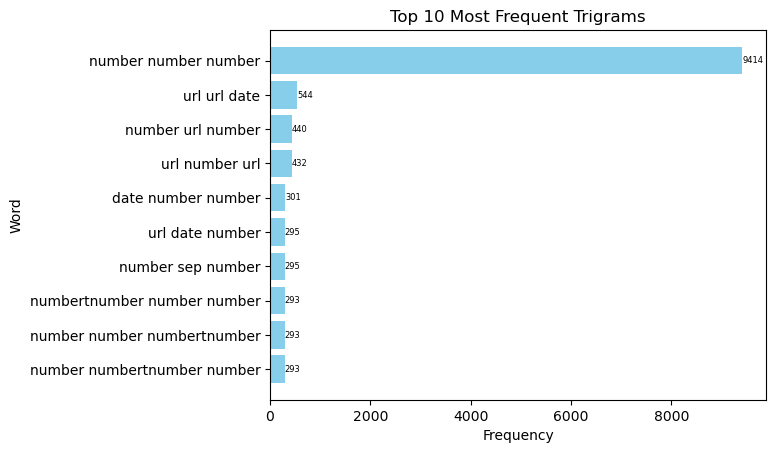

In [45]:
## chart to see highest freq word and their count
top_10_trigrams = trigram_frequency_df_en.head(10)
top_10_trigrams['Frequency'] = top_10_trigrams['Frequency'].astype(int)
top_10_trigrams['Trigram'] = top_10_trigrams['Trigram'].apply(lambda x: ' '.join(x))
top_10_trigrams = top_10_trigrams.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_trigrams['Trigram'], top_10_trigrams['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Trigrams')

for index, value in enumerate(top_10_trigrams['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

In [48]:
## df_en_ham BIGRAM
bigram_count = df_en_ham['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 2))
total_bigram_count = sum(bigram_count, Counter())
bigram_frequency_df_en_ham = pd.DataFrame(total_bigram_count.items(), columns=['Bigram', 'Frequency'])
bigram_frequency_df_en_ham = bigram_frequency_df_en_ham.sort_values(by='Frequency', ascending=False)

bigram_frequency_df_en_ham.head(20)

,Bigram,Frequency
14151,"(number, number)",13546
26149,"(url, url)",1338
28957,"(number, url)",837
26146,"(mailing, list)",710
27469,"(url, number)",649
37198,"(url, date)",561
32564,"(rpm, list)",513
33648,"(sep, number)",422
26437,"(url, ________________________________________...",368
24,"(n, t)",332


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/4076128889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams_ham['Frequency'] = top_10_bigrams_ham['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/4076128889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams_ham['Bigram'] = top_10_bigrams_ham['Bigram'].apply(lambda x: ' '.join(x))


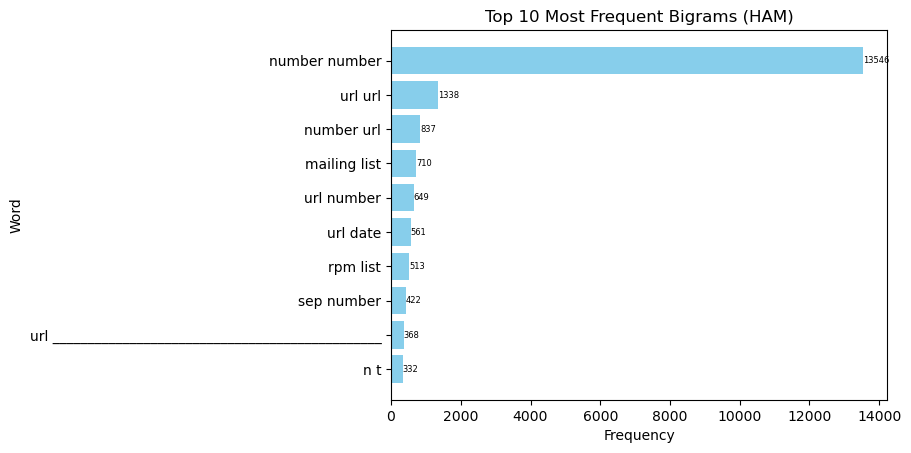

In [49]:
## chart to see highest freq word and their count
top_10_bigrams_ham = bigram_frequency_df_en_ham.head(10)
top_10_bigrams_ham['Frequency'] = top_10_bigrams_ham['Frequency'].astype(int)
top_10_bigrams_ham['Bigram'] = top_10_bigrams_ham['Bigram'].apply(lambda x: ' '.join(x))
top_10_bigrams_ham = top_10_bigrams_ham.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_bigrams_ham['Bigram'], top_10_bigrams_ham['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Bigrams (HAM)')

for index, value in enumerate(top_10_bigrams_ham['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

In [50]:
## df_en_ham TRIGRAM
trigram_count = df_en_ham['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 3))
total_trigram_count = sum(trigram_count, Counter())
trigram_frequency_df_en_ham = pd.DataFrame(total_trigram_count.items(), columns=['Trigram', 'Frequency'])
trigram_frequency_df_en_ham = trigram_frequency_df_en_ham.sort_values(by='Frequency', ascending=False)

trigram_frequency_df_en_ham.head(20)

,Trigram,Frequency
26392,"(number, number, number)",8231
38633,"(url, url, date)",544
34170,"(number, url, number)",440
34171,"(url, number, url)",432
38635,"(date, number, number)",298
38634,"(url, date, number)",295
34664,"(number, sep, number)",295
38636,"(number, number, numbertnumber)",293
38637,"(number, numbertnumber, number)",293
38638,"(numbertnumber, number, number)",293


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/3920992235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams_ham['Frequency'] = top_10_trigrams_ham['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/3920992235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams_ham['Trigram'] = top_10_trigrams_ham['Trigram'].apply(lambda x: ' '.join(x))


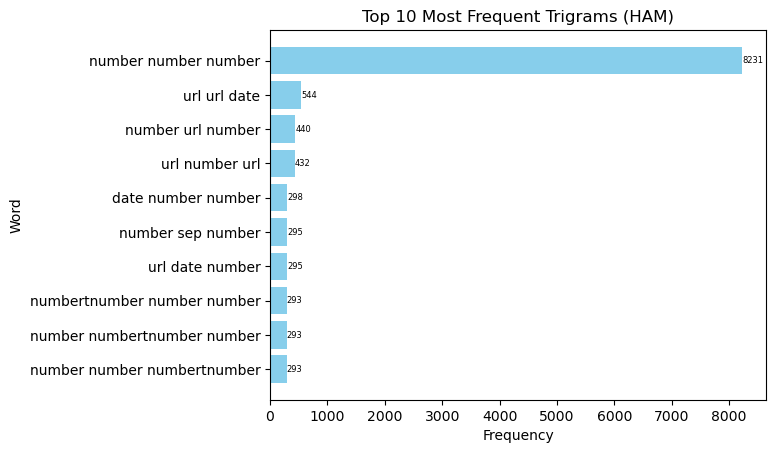

In [51]:
## chart to see highest freq word and their count
top_10_trigrams_ham = trigram_frequency_df_en_ham.head(10)
top_10_trigrams_ham['Frequency'] = top_10_trigrams_ham['Frequency'].astype(int)
top_10_trigrams_ham['Trigram'] = top_10_trigrams_ham['Trigram'].apply(lambda x: ' '.join(x))
top_10_trigrams_ham = top_10_trigrams_ham.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_trigrams_ham['Trigram'], top_10_trigrams_ham['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Trigrams (HAM)')

for index, value in enumerate(top_10_trigrams_ham['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

In [52]:
## df_en_spam BIGRAM
bigram_count = df_en_spam['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 2))
total_bigram_count = sum(bigram_count, Counter())
bigram_frequency_df_en_spam = pd.DataFrame(total_bigram_count.items(), columns=['Bigram', 'Frequency'])
bigram_frequency_df_en_spam = bigram_frequency_df_en_spam.sort_values(by='Frequency', ascending=False)

bigram_frequency_df_en_spam.head(20)

,Bigram,Frequency
6623,"(number, number)",2642
6608,"(e, mail)",289
9604,"(report, number)",181
7477,"(hyperlink, hyperlink)",164
6585,"(hyperlink, click)",151
8798,"(e, mails)",110
6694,"(number, million)",95
6665,"(url, url)",94
2339,"(name, address)",83
9518,"(number, people)",78


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/555929207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams_spam['Frequency'] = top_10_bigrams_spam['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/555929207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_bigrams_spam['Bigram'] = top_10_bigrams_spam['Bigram'].apply(lambda x: ' '.join(x))


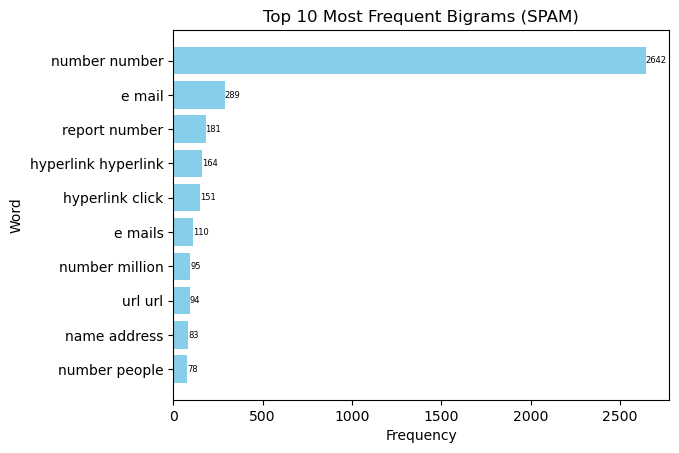

In [53]:
## chart to see highest freq word and their count
top_10_bigrams_spam = bigram_frequency_df_en_spam.head(10)
top_10_bigrams_spam['Frequency'] = top_10_bigrams_spam['Frequency'].astype(int)
top_10_bigrams_spam['Bigram'] = top_10_bigrams_spam['Bigram'].apply(lambda x: ' '.join(x))
top_10_bigrams_spam = top_10_bigrams_spam.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_bigrams_spam['Bigram'], top_10_bigrams_spam['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Bigrams (SPAM)')

for index, value in enumerate(top_10_bigrams_spam['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

In [54]:
## df_en_spam TRIGRAM
trigram_count = df_en_spam['cleaned_email'].apply(lambda x: tokenize_count_ngrams(x, 2))
total_trigram_count = sum(trigram_count, Counter())
trigram_frequency_df_en_spam = pd.DataFrame(total_trigram_count.items(), columns=['Trigram', 'Frequency'])
trigram_frequency_df_en_spam = trigram_frequency_df_en_spam.sort_values(by='Frequency', ascending=False)

trigram_frequency_df_en_spam.head(20)

,Trigram,Frequency
6623,"(number, number)",2642
6608,"(e, mail)",289
9604,"(report, number)",181
7477,"(hyperlink, hyperlink)",164
6585,"(hyperlink, click)",151
8798,"(e, mails)",110
6694,"(number, million)",95
6665,"(url, url)",94
2339,"(name, address)",83
9518,"(number, people)",78


/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/1433536651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams_spam['Frequency'] = top_10_trigrams_spam['Frequency'].astype(int)
/var/folders/g6/m9mjx8gn46xg9qvcz4921f_c0000gn/T/ipykernel_6686/1433536651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_trigrams_spam['Trigram'] = top_10_trigrams_spam['Trigram'].apply(lambda x: ' '.join(x))


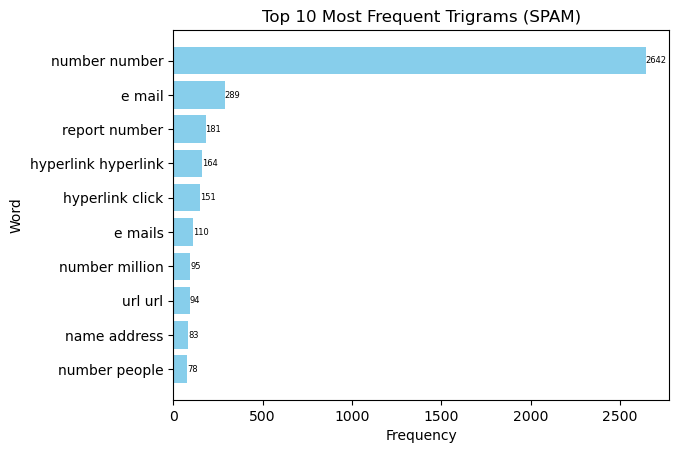

In [55]:
## chart to see highest freq word and their count
top_10_trigrams_spam = trigram_frequency_df_en_spam.head(10)
top_10_trigrams_spam['Frequency'] = top_10_trigrams_spam['Frequency'].astype(int)
top_10_trigrams_spam['Trigram'] = top_10_trigrams_spam['Trigram'].apply(lambda x: ' '.join(x))
top_10_trigrams_spam = top_10_trigrams_spam.sort_values(by = 'Frequency', ascending = True)

plt.barh(top_10_trigrams_spam['Trigram'], top_10_trigrams_spam['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Trigrams (SPAM)')

for index, value in enumerate(top_10_trigrams_spam['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

plt.show()

### ATTEMPT1: NOT dropping non-english emails --> translation

In [60]:
df_all_languages = df.copy()

In [61]:
df_all_languages.head()

,label,email,language
0,0,"go until jurong point, crazy.. available only ...",en
1,0,ok lar... joking wif u oni...,hr
2,1,free entry in 2 a wkly comp to win fa cup fina...,en
3,0,u dun say so early hor... u c already then say...,so
4,0,"nah i don't think he goes to usf, he lives aro...",en


In [62]:
df_all_languages.shape

(8029, 3)

In [63]:
def translate_to_english(text):
    if text and len(text) > 3:
        language = detect(text)
        if language != 'en':
            translator = Translator()
            translated_text = translator.translate(text, src=language, dest='en').text
            return translated_text
    return text
    
df_all_languages['email'] = df_all_languages['email'].apply(translate_to_english)

LangDetectException: No features in text.